In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scipy
import datetime
import statistics as stats
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
from sklearn.preprocessing import StandardScaler

from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from sqlalchemy import create_engine
import pandas.io.sql as pd_sql

#!jt -r
!jt -t monokai -f fira -fs 13 -nf ptsans -nfs 11 -N -kl -cursw 5 -cursc r -cellw 95% -T

## Creating Reference to Project Directories

In [2]:
project_dir = str(os.path.dirname((os.path.abspath(''))))
sys.path.append(project_dir)
print(project_dir)
figures_folder = project_dir + '/Images/'
base_path = project_dir + '/data/'
file_name = 'framingham.csv'
print(base_path + file_name)


/Users/samypalaniappan/Desktop/03_Project3
/Users/samypalaniappan/Desktop/03_Project3/data/framingham.csv


## Data Import

In [3]:
def data_import(file_name):
    file = base_path + file_name
    df = pd.read_csv(file, delimiter=',')
    df.info()
    print(df.shape)
    df.head()
    df.describe()
    return df

In [4]:
def feature_select(df, cols):
    df['MAP']= ((2*df['diaBP'])+df['sysBP'])/3
    df = df[cols]
    return df


In [5]:
file_name = 'framingham.csv'
df = data_import(file_name)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
male               4238 non-null int64
age                4238 non-null int64
education          4133 non-null float64
currentSmoker      4238 non-null int64
cigsPerDay         4209 non-null float64
BPMeds             4185 non-null float64
prevalentStroke    4238 non-null int64
prevalentHyp       4238 non-null int64
diabetes           4238 non-null int64
totChol            4188 non-null float64
sysBP              4238 non-null float64
diaBP              4238 non-null float64
BMI                4219 non-null float64
heartRate          4237 non-null float64
glucose            3850 non-null float64
TenYearCHD         4238 non-null int64
dtypes: float64(9), int64(7)
memory usage: 529.9 KB
(4238, 16)


## Inspective data for Null-Values

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

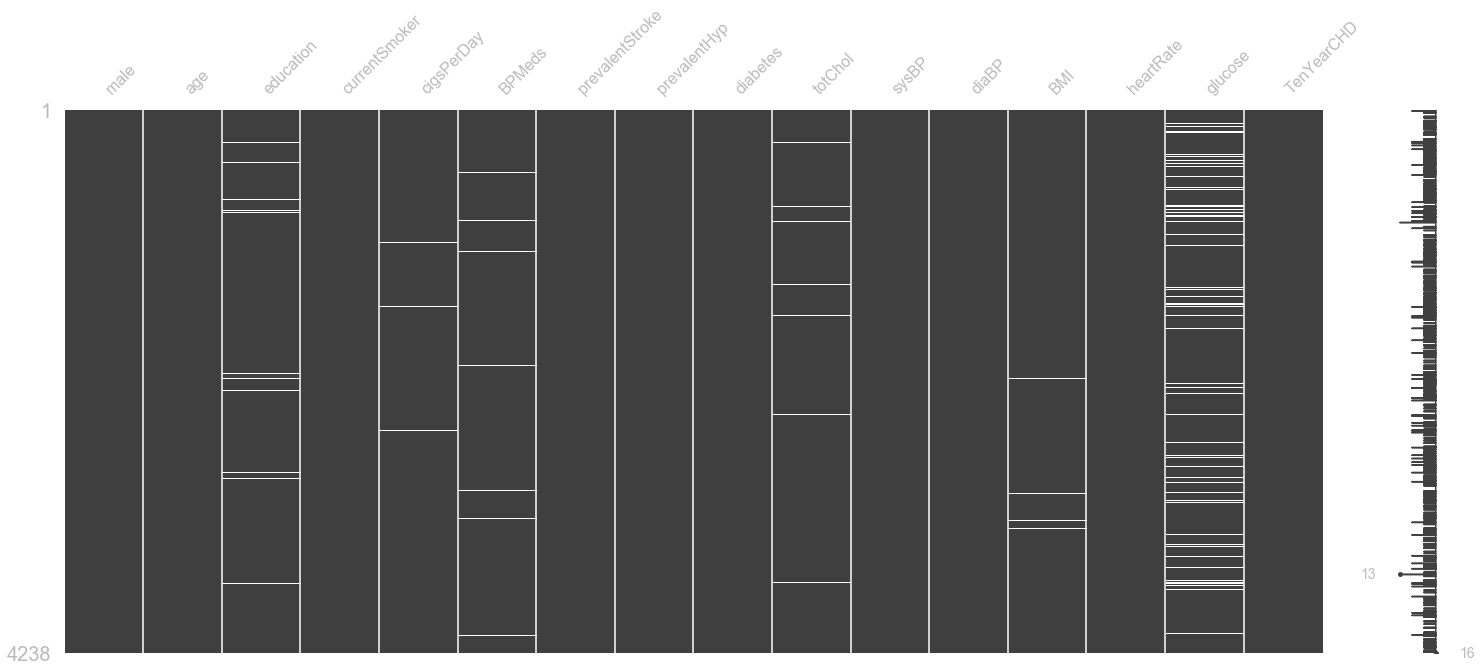

In [6]:
msno.matrix(df.sample(4238))
file_path = figures_folder + 'EDA_NullVal_Dist.png'
plt.savefig(file_path, format='png')
df.isnull().sum()
#df = df.dropna()

In [7]:
mask1 = df.glucose.isnull()
df_glu_null = df[mask1]
print(df_glu_null.shape)
mask2 = df_glu_null.diabetes == 1
df_glu_null_dia_1 = df_glu_null[mask2]
df_glu_null_dia_1
print(f'The mean BMI of people with null glucose value is ',df_glu_null.BMI.mean())
##

(388, 16)
The mean BMI of people with null glucose value is  25.7177545691906


Of the 388 records, where glucose was null - only 4 had diabetes. Also the mean BMI value of the people who had null for their glucose was in the normal BMI range. It can be safely assumed that glucose tests were not done as there was no need, since they did not have diabetes. So we replaced the cases where glucose was null and diabetes was 0, with the mean glucose values.

In [8]:
mask3 = df.diabetes == 0
df.loc[df['glucose'].isnull() & mask3, 'glucose'] = df.glucose.mean()
mask4 = df.glucose.isnull()
df_glu_null = df[mask4]
print(f'number of records with null glucose',df_glu_null.shape[0])

number of records with null glucose 4


In [9]:
mask5 = df.totChol.isnull()
df_chol_null = df[mask5]
print(f'number of records with null chol', df_chol_null.shape[0])
mask6 = df_chol_null.TenYearCHD == 0 
df_chol_null_noCHD = df_chol_null[mask6]
df_noCHD = df[df['TenYearCHD']==0]
print(f'number of records with null chol and no CHD is ',df_chol_null_noCHD.shape[0])
df.loc[df['totChol'].isnull() & mask6, 'totChol'] = df_noCHD.totChol.mean()
print(df.totChol.mean())
print(df_noCHD.totChol.mean())
#print(f'number of records with null Chol',df.totChol.shape[0])

number of records with null chol 50
number of records with null chol and no CHD is  41
236.70656744868785
235.17253025612158


In [10]:
df.loc[df['education'].isnull(), 'education'] = df.education.median()
mask7 = df.totChol > df.totChol.mean()
df.loc[df['BMI'].isnull() & mask7, 'BMI'] = df_noCHD.totChol.mean()
df = df.dropna()
df.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [11]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Sanity Checks

### Exploring relations between features and explicit feature effects on target.

In [12]:
df.groupby(['TenYearCHD']).mean()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
TenYearCHD,,,,,,,,,,,,,,,
0,0.411430,48.726471,2.002275,0.486779,8.722206,0.023600,0.003981,0.275803,0.018766,235.218291,130.282059,82.151834,25.855356,75.743531,80.768295
1,0.547231,54.153094,1.853420,0.517915,10.731270,0.063518,0.013029,0.501629,0.060261,245.311075,143.558632,87.070033,27.563726,76.573290,88.725901


In [13]:
df.groupby(['prevalentHyp']).mean()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
prevalentHyp,,,,,,,,,,,,,,,
0,0.428672,47.786190,2.035051,0.525412,9.540834,0.000000,0.002103,0.016474,231.895840,122.030845,77.990887,25.200616,74.681739,80.650294,0.107256
1,0.438185,53.432707,1.857590,0.415493,7.859937,0.095462,0.012520,0.043818,247.484271,155.080595,93.803599,28.137760,78.512520,84.854858,0.241002


In [14]:
df.groupby(['currentSmoker']).mean()

,male,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
currentSmoker,,,,,,,,,,,,,,,
0,0.336030,51.336506,1.962399,0.000000,0.037125,0.007615,0.355545,0.031890,238.838370,135.050214,84.124703,26.882818,75.142313,83.156694,0.140885
1,0.530542,47.666502,1.998522,18.357143,0.021675,0.002956,0.261576,0.017734,234.524292,129.362808,81.597537,25.308677,76.616749,80.703243,0.156650


In [15]:
df.groupby(['education']).mean()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
education,,,,,,,,,,,,,,,
1.0,0.456067,51.878063,0.465033,8.683802,0.031082,0.007173,0.358637,0.034071,238.086527,135.712791,83.902271,26.943615,76.074716,82.964921,0.184100
2.0,0.402108,47.423946,0.534639,9.755271,0.030120,0.005271,0.287651,0.018825,235.575744,130.910392,82.457078,25.738159,76.521837,81.179802,0.115964
3.0,0.325859,48.838565,0.461883,8.073244,0.025411,0.004484,0.260090,0.017937,237.038917,129.404335,81.748132,25.334144,75.866966,82.017895,0.128550
4.0,0.581345,48.106291,0.505423,9.503254,0.028200,0.000000,0.264642,0.019523,234.579924,127.720174,82.056399,25.275336,73.225597,80.396392,0.143167


In [16]:
df.groupby(pd.cut(df['diaBP'], 4)).mean()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
diaBP,,,,,,,,,,,,,,,,
"(47.906, 71.625]",0.335357,47.301973,2.056146,0.585736,10.016692,0.004552,0.003035,0.031866,0.013657,222.958088,111.543247,66.777693,23.967758,73.289833,80.200614,0.104704
"(71.625, 95.25]",0.446043,49.398424,1.974649,0.484070,8.971223,0.020555,0.004454,0.256595,0.024323,238.113727,130.581192,82.505824,26.013319,75.751627,81.595132,0.137376
"(95.25, 118.875]",0.477583,52.738791,1.927875,0.423002,8.364522,0.103314,0.013645,0.914230,0.037037,246.398066,163.100390,102.344055,28.932174,79.372320,85.474731,0.241715
"(118.875, 142.5]",0.375000,55.000000,1.800000,0.350000,4.650000,0.150000,0.000000,0.975000,0.100000,237.454313,200.075000,126.137500,32.189500,81.775000,91.571675,0.500000


In [17]:
df.groupby(pd.cut(df['sysBP'], 4)).mean()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
sysBP,,,,,,,,,,,,,,,,
"(83.288, 136.375]",0.445725,47.400000,2.062454,0.530855,9.676208,0.007435,0.002230,0.072491,0.015242,230.994604,119.526394,77.478067,25.262635,74.597026,80.378446,0.103346
"(136.375, 189.25]",0.415988,53.207994,1.842339,0.424130,7.954108,0.059956,0.011103,0.737232,0.037010,246.627863,152.853442,91.881939,27.389145,78.021466,83.637980,0.218357
"(189.25, 242.125]",0.255814,58.116279,1.593023,0.337209,5.697674,0.220930,0.011628,0.965116,0.139535,259.651163,201.000000,108.244186,32.257820,81.209302,104.451942,0.441860
"(242.125, 295.0]",0.000000,58.250000,1.500000,0.000000,0.000000,0.500000,0.000000,1.000000,0.000000,246.000000,257.500000,132.875000,31.005000,87.250000,86.000000,0.750000


### Exploring relations between systolic and diastolic BP

Text(0,0.5,'Frequency')

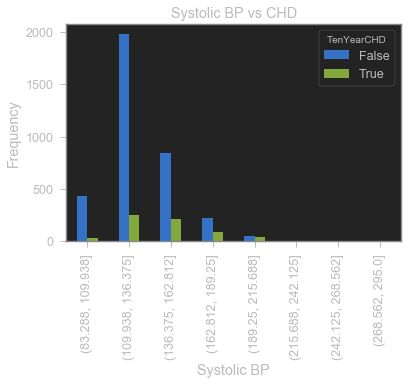

In [18]:
sys_cat =pd.cut(df['sysBP'], 8)
sys_cat = sys_cat.to_frame()
sys_cat.columns = ['sys_cat']
df_new = pd.concat([df, sys_cat], axis=1)
pd.crosstab(df_new.sys_cat, df_new.TenYearCHD.astype(bool)).plot(kind='bar')
plt.title('Systolic BP vs CHD')
plt.xlabel('Systolic BP')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

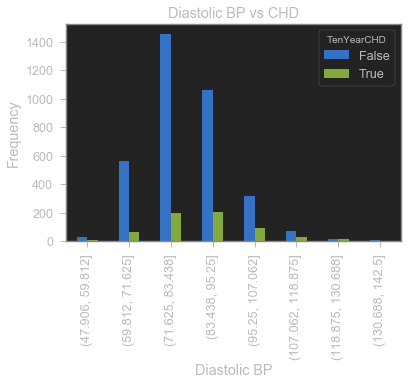

In [19]:
dia_cat =pd.cut(df['diaBP'], 8)
dia_cat = dia_cat.to_frame()
dia_cat.columns = ['dia_cat']
df_new = pd.concat([df, dia_cat], axis=1)
pd.crosstab(df_new.dia_cat, df_new.TenYearCHD.astype(bool)).plot(kind='bar')
plt.title('Diastolic BP vs CHD')
plt.xlabel('Diastolic BP')
plt.ylabel('Frequency')

### Distribution of features

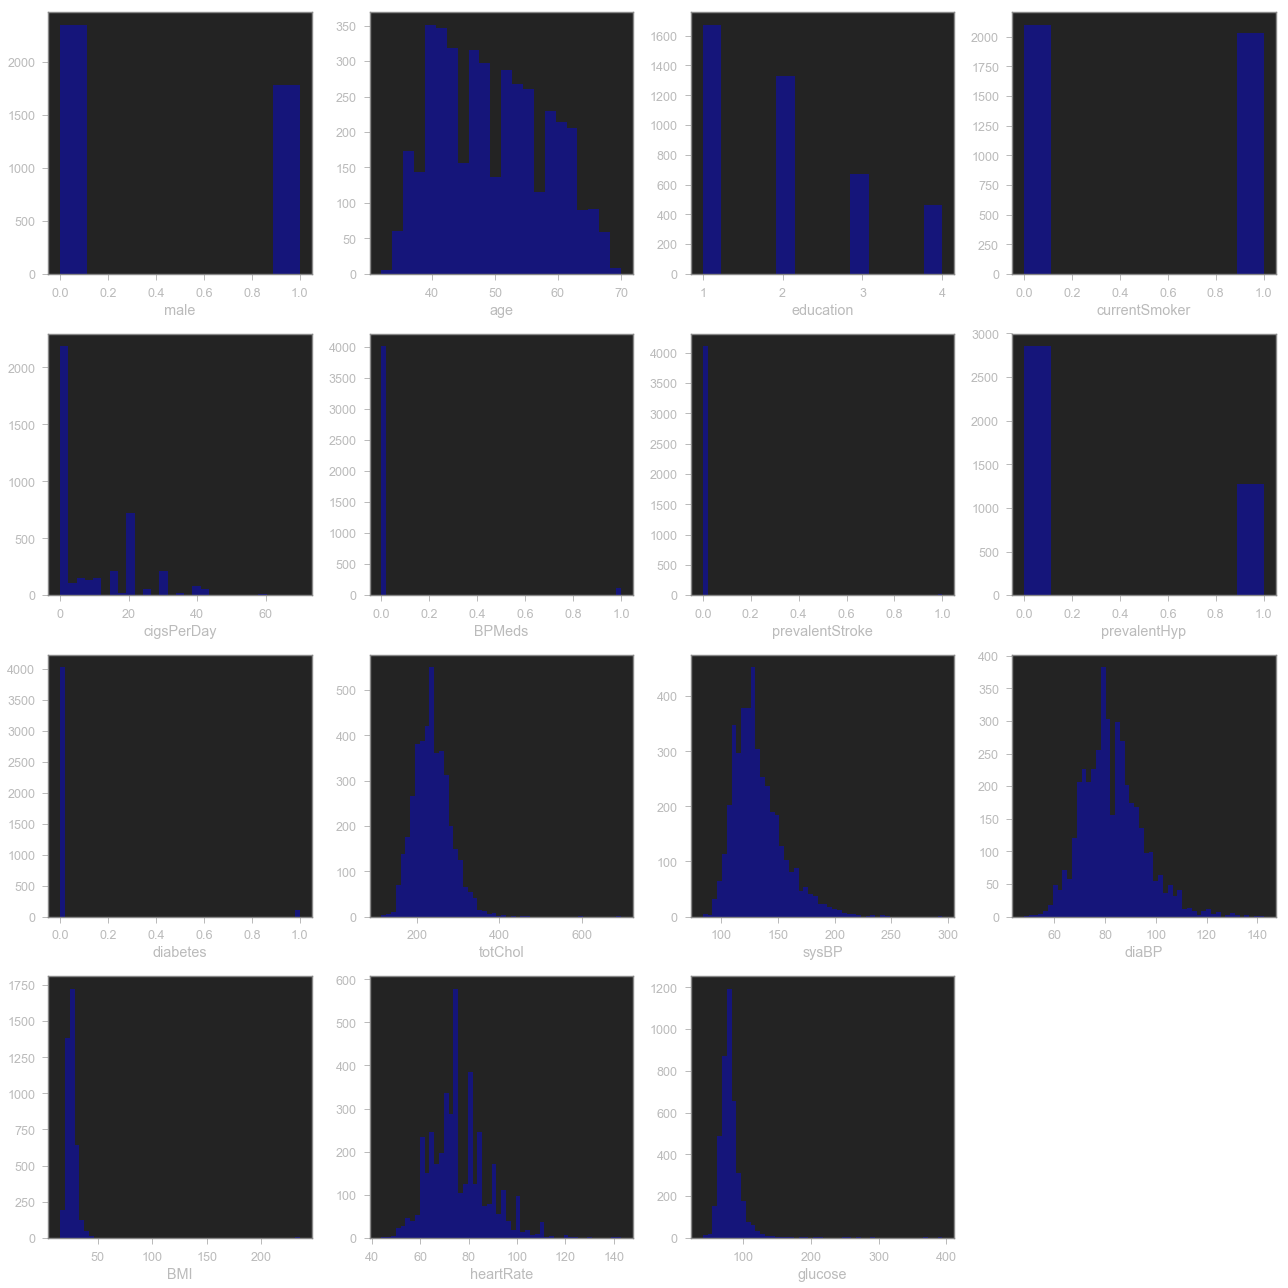

In [20]:
fig, ax = plt.subplots(figsize = (18, 18))
for i, col in enumerate(df.columns[1:]):
    plt.subplot(4, 4, i+1)
    sns.distplot(df.iloc[:,i],kde=False,ax=plt.gca(), color='blue')
    #plt.title(df.columns[i])
    plt.axis('on')
plt.tight_layout()

In [21]:
col_cont = [ 'age', 'education', 'totChol', 'sysBP','diaBP', 'BMI', 'heartRate', 'glucose', 'cigsPerDay']
col_disc = ['TenYearCHD', 'male', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

### Scaling Features

In [22]:
df_disc = df[col_disc]
df_cont = df[col_cont]
std = StandardScaler()
std.fit_transform(df_cont.values)
df_cont = std.transform(df_cont.values)
df_cont = pd.DataFrame(df_cont)
df_cont.columns = col_cont
df_cont.head()

,age,education,totChol,sysBP,diaBP,BMI,heartRate,glucose,cigsPerDay
0,-1.230197,2.006927,-0.942980,-1.194067,-1.085993,0.096125,0.342776,-0.215105,-0.756377
1,-0.412638,0.019723,0.300210,-0.511883,-0.158719,0.292679,1.586779,-0.258551,-0.756377
2,-0.179050,-0.973879,0.187193,-0.216270,-0.243016,-0.085912,-0.071892,-0.519229,0.920582
3,1.339273,1.013325,-0.264876,0.807006,1.021448,0.275927,-0.901227,0.914498,1.759062
4,-0.412638,1.013325,1.091331,-0.102573,0.094174,-0.336072,0.757444,0.132465,1.172126


In [23]:
scaled_df = pd.concat([df_disc, df_cont], axis=1, sort=False)
scaled_df.head()
scaled_df = df.dropna()
scaled_df.shape

(4131, 16)

### Correlation between Features

/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


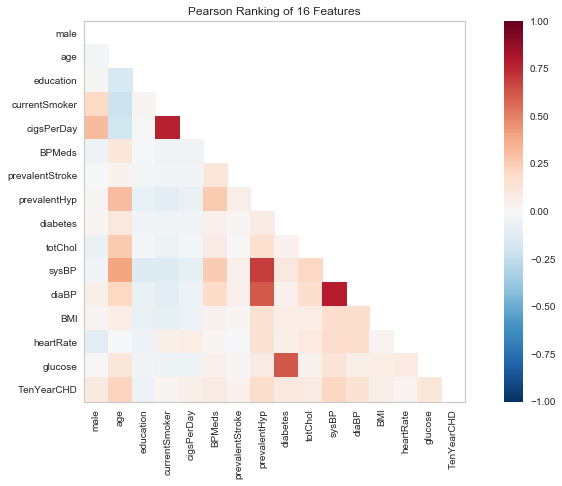

In [24]:
from yellowbrick.features import Rank2D

# Modify the figure size
fig, ax=plt.subplots(figsize=(14,7))

# Instantiate the Rank2D object with default arguments: visualizer
visualizer = Rank2D(algorithm="pearson")

# fit the visualizer
visualizer.fit_transform(df)
# Plot the visualizer with .poof() method
visualizer.poof()

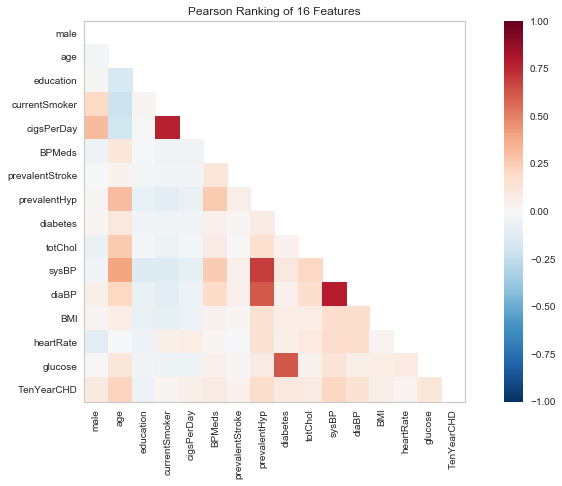

In [25]:
# Modify the figure size
fig, ax=plt.subplots(figsize=(14,7))
# Instantiate the Rank2D object with default arguments: visualizer
visualizer = Rank2D(algorithm="pearson")
# fit the visualizer
visualizer.fit_transform(scaled_df)
# Plot the visualizer with .poof() method
visualizer.poof()

In [26]:
corr = scaled_df.corr()
corr.style.background_gradient()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
male,1,-0.0239409,0.0128164,0.196328,0.317382,-0.050974,-0.00332747,0.00887796,0.0173767,-0.0655212,-0.0324485,0.0603118,0.0297812,-0.117043,0.00476945,0.0975324
age,-0.0239409,1,-0.160215,-0.214286,-0.190873,0.122408,0.0436131,0.304833,0.107181,0.260676,0.394224,0.207544,0.0714687,-0.0139016,0.115829,0.225458
education,0.0128164,-0.160215,1,0.0179434,0.00755687,-0.00934607,-0.0282992,-0.0815035,-0.0384959,-0.0219974,-0.129876,-0.0654212,-0.0720771,-0.0555121,-0.0322365,-0.0526126
currentSmoker,0.196328,-0.214286,0.0179434,1,0.769491,-0.0456247,-0.032007,-0.101631,-0.0453864,-0.0487493,-0.12931,-0.106501,-0.0878859,0.0611311,-0.0532888,0.0221556
cigsPerDay,0.317382,-0.190873,0.00755687,0.769491,1,-0.0445451,-0.0333141,-0.065147,-0.0386809,-0.0270132,-0.0880076,-0.0538154,-0.0571391,0.0730738,-0.0538843,0.0599241
BPMeds,-0.050974,0.122408,-0.00934607,-0.0456247,-0.0445451,1,0.124759,0.260644,0.0546391,0.0813408,0.257118,0.195063,0.0403896,0.0158007,0.0496182,0.0838772
prevalentStroke,-0.00332747,0.0436131,-0.0282992,-0.032007,-0.0333141,0.124759,1,0.0661545,0.00963022,0.00760773,0.0539827,0.0483861,0.0113089,-0.0118805,0.0150345,0.0442257
prevalentHyp,0.00887796,0.304833,-0.0815035,-0.101631,-0.065147,0.260644,0.0661545,1,0.0810633,0.162869,0.694768,0.616145,0.15162,0.146852,0.0844374,0.173791
diabetes,0.0173767,0.107181,-0.0384959,-0.0453864,-0.0386809,0.0546391,0.00963022,0.0810633,1,0.0461816,0.107195,0.0522929,0.0709565,0.0563582,0.619406,0.094667
totChol,-0.0655212,0.260676,-0.0219974,-0.0487493,-0.0270132,0.0813408,0.00760773,0.162869,0.0461816,1,0.209904,0.166362,0.0734237,0.0880191,0.0441009,0.0811523


In [27]:
corr_mask = corr.apply(lambda col: (abs(col)> 0.75) & (abs(col)!=1))
corr_mask.sum()

male               0
age                0
education          0
currentSmoker      1
cigsPerDay         1
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              1
diaBP              1
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

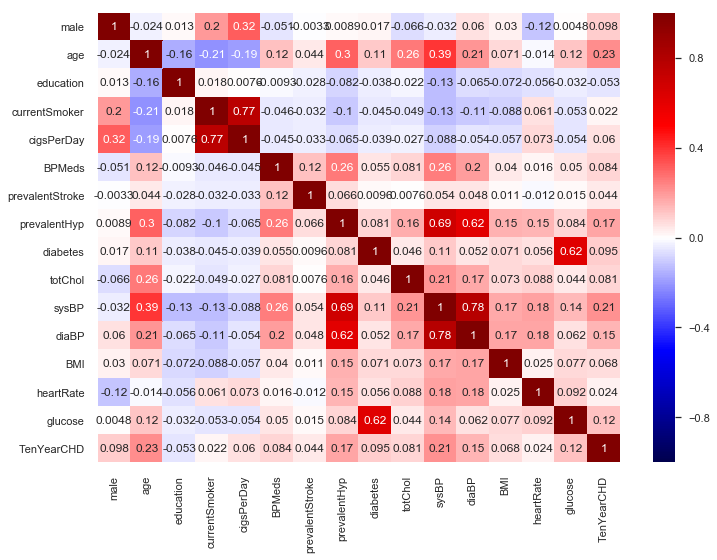

In [28]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df.corr(method='pearson'), cmap="seismic", annot=True, vmin=-1, vmax=1);

/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


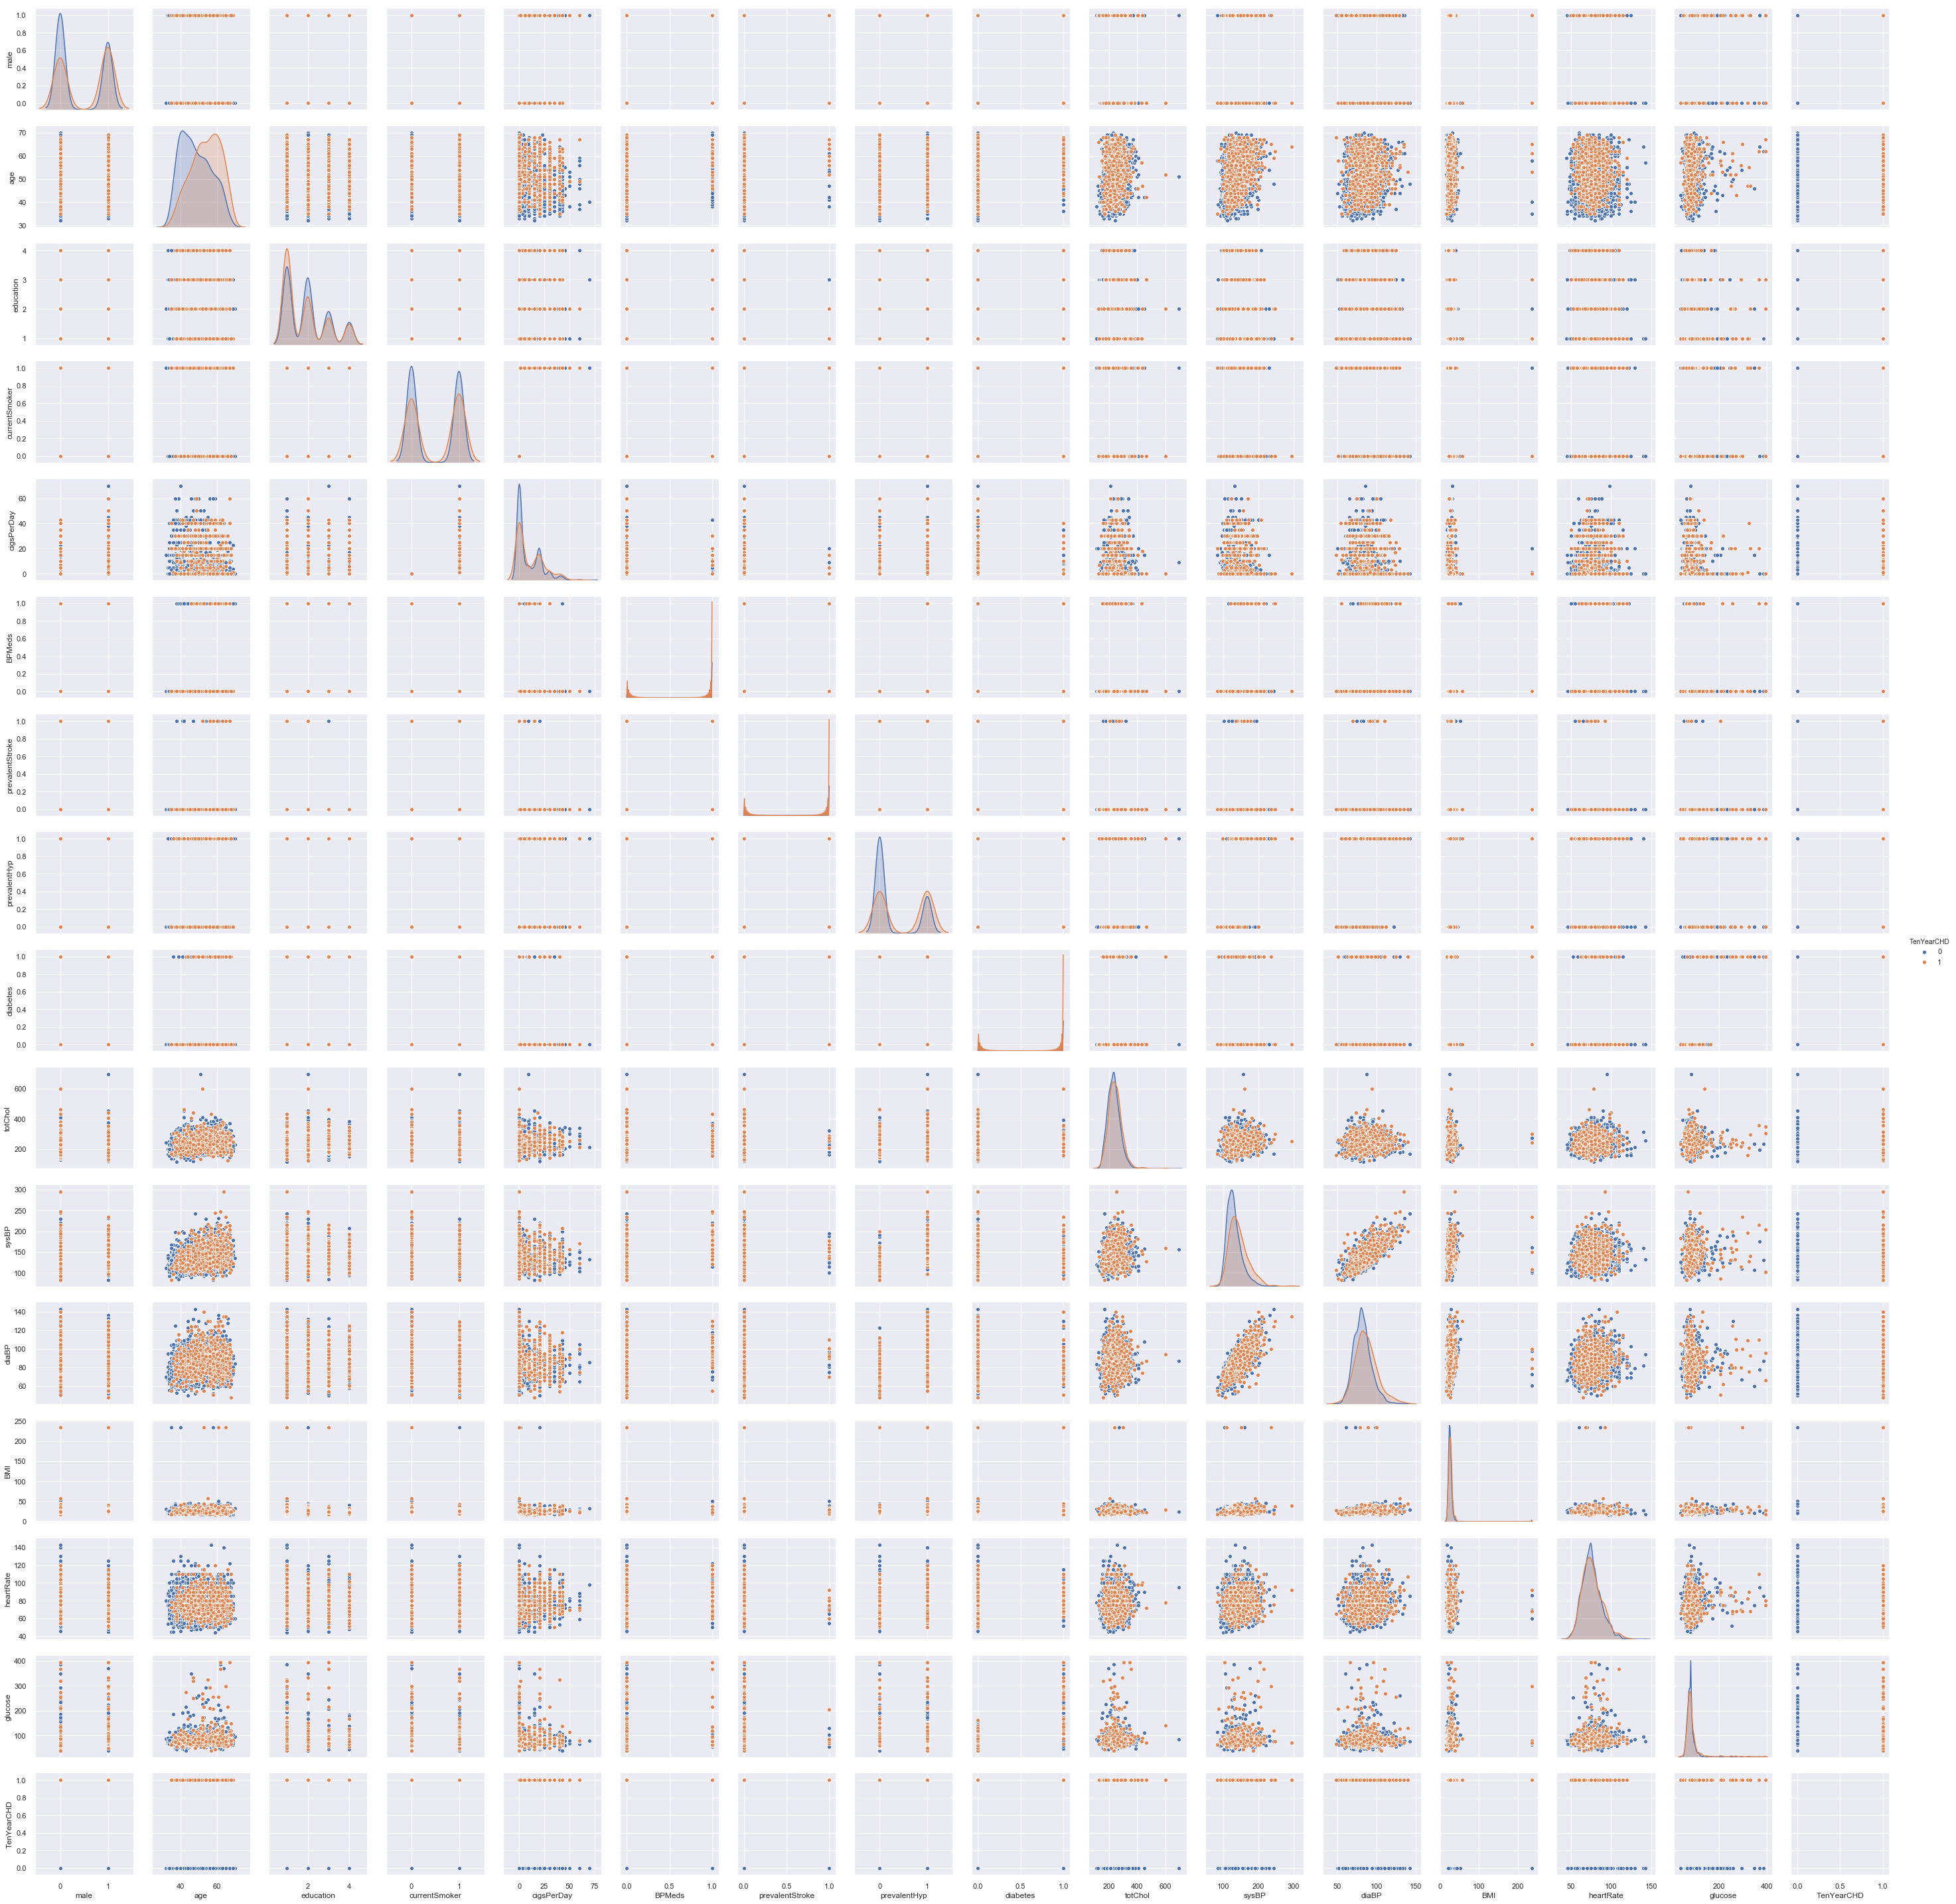

In [29]:
sns.pairplot(df, hue='TenYearCHD');

## Feature Selection

In [30]:
df.isnull().sum()
df.columns
cols = ['age', 'totChol', 'MAP', 'BMI', 'cigsPerDay', 'heartRate', \
                      'glucose', 'male', 'prevalentHyp', 'TenYearCHD']
df = feature_select(df, cols)
df.head()

,age,totChol,MAP,BMI,cigsPerDay,heartRate,glucose,male,prevalentHyp,TenYearCHD
0,39,195.0,82.000000,26.97,0.0,80.0,77.0,1,0,0
1,46,250.0,94.333333,28.73,0.0,95.0,76.0,0,0,0
2,48,245.0,95.833333,25.34,20.0,75.0,70.0,1,0,0
3,61,225.0,113.333333,28.58,30.0,65.0,103.0,0,1,1
4,46,285.0,99.333333,23.10,23.0,85.0,85.0,0,0,0


## Upload to SQL on AWS and return as DF

In [31]:
# Postgres info to connect
params = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'port': 5432,         # port we opened on AWS
    'dbname': 'framingham',
    'user': 'samypalaniappan'
}

# sqlalchemy engine
sql_eng = create_engine(
    'postgresql+psycopg2://',
    connect_args=params
)

# connection
connection = sql_eng.connect()

In [32]:
def new_table(connection, df, table_name='Data'):
    # copy column headers
    pd_sql.to_sql(df, table_name, connection, if_exists='replace', index=False)


In [33]:
connection_string = f'postgres://samypalaniappan:{params["host"]}@{params["host"]}:{params["port"]}/framingham'
engine = create_engine(connection_string)
conn= engine.connect()

In [34]:
new_table(connection=conn, df=df, table_name='Data')

In [35]:
def psql_to_df(query, params=params, col=cols):
    connection = connect(**params)
    cursor = connection.cursor()
    cursor.execute(query)
    return pd.DataFrame(cursor.fetchall(), columns=col) 

In [36]:
query = """
SELECT * FROM "Data";
"""
final_df = psql_to_df(query)
final_df.head()

,age,totChol,MAP,BMI,cigsPerDay,heartRate,glucose,male,prevalentHyp,TenYearCHD
0,39,195.0,82.000000,26.97,0.0,80.0,77.0,1,0,0
1,46,250.0,94.333333,28.73,0.0,95.0,76.0,0,0,0
2,48,245.0,95.833333,25.34,20.0,75.0,70.0,1,0,0
3,61,225.0,113.333333,28.58,30.0,65.0,103.0,0,1,1
4,46,285.0,99.333333,23.10,23.0,85.0,85.0,0,0,0


In [37]:
final_df.to_csv(base_path+"preprocessed_data.csv")